# Principal Component Analysis of Trajectory 

In [840]:
# Imports necessary
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import mdtraj as md
from sklearn.preprocessing import normalize
from matplotlib import cm
from matplotlib.colors import ListedColormap

## Load Trajectories
Duello is used on the Cgn protein with the three different Calvados3 models. The original one, one with added side-chains and one with added polarization. All three trajectories and free energy values are loaded and converted to numpy. 
For Duello a resolution of 0.8 was used, pH 7, salt concentration 0.05 M and temperature 298 K; for all calculations.

In [534]:
# Original Calvados
traj_org = md.load('Cgn_data/traj_org.xtc', top='Cgn_data/confout_cgn.pdb')
data = pd.read_csv('Cgn_data/traj_org.energy.dat.gz', header=None)
# Convert to numpy array
energy = data.to_numpy().astype(float)
energy = energy.flatten()

# Normalize the energy
Rgas = 8.31446261815324  # J/(mol*K)
T = 298  # Temperature in Kelvin
# Convert energy
# Convert to dimensionless energy
energy_org = np.exp(-energy/Rgas/T)
#if you need a smaller PCA size
#mask = np.abs(energy_org) >= 0.1  # Mask to filter out low energy states
#energy_org = energy[mask]
#traj_org = traj_org[mask]  # Downsample the trajectory
print(len(traj_org), len(energy_org))
print(np.min(energy_org), np.max(energy_org))

traj_org = traj_org.atom_slice([i for i in range(traj_org.n_atoms) if i not in [240, 482]]) # Exclude atoms 240 and 481 because missing from experiments
# Inspect number of frames and atoms
print(f"Number of frames: {traj_org.n_frames}")
print(f"Number of atoms: {traj_org.n_atoms}")

/opt/homebrew/Caskroom/mambaforge/base/envs/pca/lib/python3.11/site-packages/mdtraj/formats/pdb/pdbfile.py:198: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/opt/homebrew/Caskroom/mambaforge/base/envs/pca/lib/python3.11/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


21168 21168
0.0 1.008018970328767
Number of frames: 21168
Number of atoms: 482


In [834]:
# Calvados with polarization
# Now load the trajectory using the .pdb topology
traj_pol = md.load('Cgn_data/traj_pol.xtc', top='Cgn_data/confout_cgn.pdb')
data = pd.read_csv('Cgn_data/traj_pol.energy.dat.gz', header=None)
# Convert to numpy array
energy = data.to_numpy().astype(float)
energy = energy.flatten()

# Normalize the energy
energy_pol = np.exp(-energy/Rgas/T)
#mask = np.abs(energy_pol) >= 0.15  # Mask to filter out low energy states
#energy_pol = energy_pol[mask]
#traj_pol = traj_pol[mask]  # Downsample the trajectory
print(len(traj_pol), len(energy_pol))
print(np.min(energy_pol), np.max(energy_pol))

traj_pol = traj_pol.atom_slice([i for i in range(traj_pol.n_atoms) if i not in [240, 482]]) # Exclude atoms 240 and 481
# Inspect number of frames and atoms
print(f"Number of frames: {traj_pol.n_frames}")
print(f"Number of atoms: {traj_pol.n_atoms}")

/opt/homebrew/Caskroom/mambaforge/base/envs/pca/lib/python3.11/site-packages/mdtraj/formats/pdb/pdbfile.py:198: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/opt/homebrew/Caskroom/mambaforge/base/envs/pca/lib/python3.11/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


21168 21168
0.0 1.0087401914184655
Number of frames: 21168
Number of atoms: 482


In [835]:
#Calvados with side chains
traj_sch = md.load('Cgn_data/traj_sch.xtc', top='Cgn_data/confout_cgn.pdb')
data = pd.read_csv('Cgn_data/traj_sch.energy.dat.gz', header=None)
# Convert to numpy array
energy = data.to_numpy().astype(float)
energy = energy.flatten()

# Convert energy
energy_sch = np.exp(-energy/Rgas/T)
#mask = np.abs(energy_sch) >= 0.1  # Mask to filter out low energy states
#energy_sch = energy_sch[mask]
#traj_sch = traj_sch[mask]  # Downsample the trajectory
print(len(traj_sch), len(energy_sch))
print(np.min(energy_sch), np.max(energy_sch))

traj_sch = traj_sch.atom_slice([i for i in range(traj_sch.n_atoms) if i not in [240, 482]]) # Exclude atoms 240 and 481
# Inspect number of frames and atoms
print(f"Number of frames: {traj_sch.n_frames}")
print(f"Number of atoms: {traj_sch.n_atoms}")

/opt/homebrew/Caskroom/mambaforge/base/envs/pca/lib/python3.11/site-packages/mdtraj/formats/pdb/pdbfile.py:198: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/opt/homebrew/Caskroom/mambaforge/base/envs/pca/lib/python3.11/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


21168 21168
0.0 1.0068316929061483
Number of frames: 21168
Number of atoms: 482


## Generate Experimental Data
The experimental PDB files from PPI3D are loaded with mdtraj.

In [836]:
# Experimental structures:
Exp_kty = md.load('Exp_struct/1_7kty_A_1-7kty_A_2.pdb')
Exp_ktz = md.load('Exp_struct/1_7ktz_A_1-7ktz_A_2.pdb')
Exp_ku0 = md.load('Exp_struct/1_7ku0_A_1-7ku0_A_2.pdb')
Exp_ku1 = md.load('Exp_struct/1_7ku1_A_1-7ku1_A_2.pdb')
Exp_ku2 = md.load('Exp_struct/1_7ku2_A_1-7ku2_A_2.pdb')
Exp_ku3 = md.load('Exp_struct/1_7ku3_A_1-7ku3_A_2.pdb')

# Experimental structure example
print(f"Experimental structure frames: {Exp_kty.n_frames}")
print(f"Experimental structure atoms: {Exp_kty.n_atoms}")
print(f"Experimental structure topology: {Exp_kty.n_residues}")

Experimental structure frames: 1
Experimental structure atoms: 3542
Experimental structure topology: 482


In [ ]:
def center_structs(total_exp, symmetry=False):
    """
    Center the experimental structures for comparison with the trajectory.
    Parameters
    ----------
    total_exp: md.Trajectory
        The experimental trajectory to center and divide into two parts, where each part contains one protein.
    symmetry: bool
        Whether to apply symmetry operations (e.g., 180° rotation).
    Returns
    -------
    expA, expB: md.Trajectory
        The centered experimental structures with one protein each.
    """
    # Center the frames from trajectory to compare with experimental structure by taking away dimension R
    if symmetry:
        # Rotation matrix for 180° about z-axis
        #center = total_exp.xyz.mean(axis=0)
        #total_exp.xyz = total_exp.xyz - center  # Center the coordinates of the experimental structure
        total_exp = total_exp.center_coordinates()  # Center the coordinates of the experimental structure
        print(total_exp.xyz.shape)
        rotation_z = np.array([
                                [-1, 0, 0],
                                [ 0,-1, 0],
                                [ 0, 0, -1]
                              ])
        # Apply rotation
        total_exp.xyz = np.dot(total_exp.xyz, rotation_z.T)
    
    indices = np.arange(total_exp.n_atoms)
    half = total_exp.n_atoms // 2
    expA = total_exp.atom_slice(indices[:half])  # Slice the experimental structure to match the number of atoms in duello
    expB = total_exp.atom_slice(indices[half:])  # Slice the experimental structure to match the number of atoms in duello

    expA = expA.center_coordinates()  # Center the coordinates of the sliced experimental structure
    expB = expB.center_coordinates()  # Center the coordinates of the sliced experimental structure
    # Alternatively, manually center - but removes rotational freedom
    #centerA = expA.xyz.mean(axis=0)
    #centerB = expB.xyz.mean(axis=0)
    #expA.xyz = expA.xyz - centerA  # Center the coordinates of the sliced experimental structure
    #expB.xyz = expB.xyz - centerB  # Center the coordinates of the sliced experimental structure
    return expA, expB

def coarse_grain(traj):
    """
    Coarse-grain the trajectory by averaging over groups of atoms.
    Parameters
    ----------
    traj: md.Trajectory
        The trajectory to coarse-grain.
    Returns
    -------
    cg_traj: md.Trajectory
        The coarse-grained trajectory.
    """
    # Get topology and masses
    top = traj.topology

    # Allocate array for residue centers of mass
    n_frames = traj.n_frames
    n_residues = top.n_residues
    res_com = np.zeros((n_frames, n_residues, 3))

    # Compute COM for each residue
    for res in top.residues:
        atom_indices = [atom.index for atom in res.atoms]
        coords = traj.xyz[:, atom_indices, :]   # (n_frames, n_atoms_in_res, 3)
        com = coords.mean(axis=1) 
        res_com[:, res.index, :] = com
    # Create a new trajectory with the residue centers of mass
    new_top = md.Topology()
    chain = new_top.add_chain()

    for res in top.residues:
        cg_res = new_top.add_residue(res.name, chain)
        # Add a pseudo-atom for this residue (name it "BB" for backbone bead)
        new_top.add_atom("BB", element=md.element.hydrogen, residue=cg_res)
    cg_traj = md.Trajectory(res_com, new_top,time=traj.time)
    
    return cg_traj

def compare_rmsd(traj, exp, symmetry=False):
    """
    Compare the RMSD between the trajectory and the experimental structure.
    Parameters
    ----------
    traj: md.Trajectory
        The trajectory of multiple configurations to compare against.
    exp: md.Trajectory
        The experimental structure to compare.
    symmetry bool, optional
        Whether to apply symmetry operations. Defaults to False.
    Raises
    ------
        ValueError: If the number of atoms in the trajectory and experimental structure do not match.
    Returns:
    -------
    tot_rmsd, tot_rmsd_T: tuple
        The RMSD values for the comparison.

    """
    expA, expB = center_structs(exp, symmetry)
    if expA.n_atoms != expB.n_atoms:
        raise ValueError("Experimental structures must have the same number of atoms.")
    
    trajA, trajB = center_structs(traj, symmetry=False)
    if trajA.n_atoms != expA.n_residues or trajB.n_atoms != expB.n_residues:
        raise ValueError("Trajectory and experimental structures must have the same number of atoms.")
    
    X = trajA.xyz
    Y = trajB.xyz
    Z = expA.xyz
    W = expB.xyz
        
    rmsdA = np.sqrt(((X - Z)**2).sum(axis=(1,2)) / X.shape[1])
    rmsdB = np.sqrt(((Y - W)**2).sum(axis=(1,2)) / Y.shape[1])
        
    rmsdA_T = np.sqrt(((X - W)**2).sum(axis=(1,2)) / X.shape[1])
    rmsdB_T = np.sqrt(((Y - Z)**2).sum(axis=(1,2)) / Y.shape[1])
        
    tot_rmsd = (rmsdA + rmsdB) /2 # Total RMSD for both proteins in the structure
    tot_rmsd_T = (rmsdA_T + rmsdB_T) /2
    return tot_rmsd, tot_rmsd_T 

def find_closest_structure(traj, exp, cg, symmetry=False):
    """
    Find the closest structure in the trajectory to the experimental structure.
    Parameters
    ----------
    traj: md.Trajectory
        The trajectory to compare against the experimental structure. This one can consist of multiple frames.
    exp: md.Trajectory
        The experimental structure to compare with the trajectory.
    cg: bool
        Whether to use coarse-grained representations or not of the exp structure
    symmetry: bool
        Whether to rotate the exp structure 180 degrees to test symmetry. Default is False.
    Returns
    -------
    min_index: int
        The index of the closest structure in the trajectory to the experimental structure.
    r1[min_index], r2[min_index_T]: float
        The RMSD values for the closest structures.
    """
    if cg: 
        cg = coarse_grain(exp)  # Coarse-grain the experimental trajectory
    r1, r2 = compare_rmsd(traj, cg, symmetry, with_rotation=False)  # Compare RMSD without rotation
    print("Printing both minima:", np.argmin(r1), np.argmin(r2), np.min(r1), np.min(r2))  # Print minimum RMSD values
    if np.min(r1) < np.min(r2):
        print(f"Minimum first case {np.min(r1)}")
        return np.argmin(r1)
    if np.min(r2) < np.min(r1):
        print(f"Minimum second case {np.min(r2)}")
        return np.argmin(r2)
    else:
        print("Minimum both cases are equal", np.min(r1), np.min(r2))
        min_index = np.argmin(r1)
        min_index_T = np.argmin(r2)
        if min_index == min_index_T:
            print("Minimum both cases are equal and at the same index")
            return min_index
        else:
            print("Minimum both cases are equal but at different indices")
            print(f"Index in first case: {min_index}, Index in second case: {min_index_T}")
            return  r1[min_index], r2[min_index_T]


In [837]:
exp_traj = Exp_ku0 # Experimental structure for comparison - change!
index = find_closest_structure(traj_org, exp_traj, True)  # Find the closest structure in the trajectory to the experimental structure
index1 = find_closest_structure(traj_sch, exp_traj, True)  # Find the closest structure in the trajectory to the experimental structure
index2 = find_closest_structure(traj_pol, exp_traj, True)  # Find the closest structure in the trajectory to the experimental structure
print(f"Index original: {index}, Index side chain: {index1}, Index polarization: {index2}")

Printing both minima: 15703 1405 0.04290369 1.2677269
Minimum first case 0.04290369153022766
Printing both minima: 15703 1405 0.04290369 1.2677269
Minimum first case 0.04290369153022766
Printing both minima: 15703 1405 0.04290369 1.2677269
Minimum first case 0.04290369153022766
Index original: 15703, Index side chain: 15703, Index polarization: 15703


## Function used to plot the free energy

In [838]:
def plot_free_energy(xall, yall, weights=None, ax=None, nbins=50, ncountours=100,
                     avoid_zero_count=True, minener_zero=True, kT=1.0, vmin=None, vmax=None,
                     cmap='spectral', cbar=True, cbar_label='Free energy (kT)', white_bg=True, 
                     symmetry=False, x_sym=False, y_sym=False):
    """Free energy plot given 2D scattered data
    Builds a 2D-histogram of the given data points and plots -log(p) where p is
    the probability computed from the histogram count.
    Parameters
    ----------
    xall : ndarray(T)
        sample x-coordinates
    yall : ndarray(T)
        sample y-coordinates
    weights : ndarray(T), default = None
        sample weights. By default all samples have the same weight
    ax : matplotlib Axes object, default = None
        the axes to plot to. When set to None the default Axes object will be used.
    nbins : int, default=100
        number of histogram bins used in each dimension
    ncountours : int, default=100
        number of contours used
    avoid_zero_count : bool, default=True
        avoid zero counts by lifting all histogram elements to the minimum value
        before computing the free energy. If False, zero histogram counts will
        yield NaNs in the free energy which and thus regions that are not plotted.
    minener_zero : bool, default=True
        Shifts the energy minimum to zero. If false, will not shift at all.
    kT : float, default=1.0
        The value of kT in the desired energy unit. By default, will compute
        energies in kT (setting 1.0). If you want to measure the energy in
        kJ/mol at 298 K, use kT=2.479 and change the cbar_label accordingly.
    vmin : float or None, default=0.0
        Lowest energy that will be plotted
    vmax : float or None, default=None
        Highest energy that will be plotted
    cmap : matplotlib colormap, optional, default = None
        The color map to use. None will use pylab.cm.spectral.
    cbar : boolean, default=True
        Plot a color bar
    cbar_label : str or None, default='Free energy (kT)'
        Colorbar label string. Use None to suppress it.
    white_bg : boolean, dfault=True
        Adds the color white to the highest value in the color map.
    symmetry : bool, default=False
        Whether to apply symmetry operations (e.g., 180° rotation).
    x_sym : bool, default=False
        Whether to apply symmetry to the x-axis.
    y_sym : bool, default=False
        Whether to apply symmetry to the y-axis.
    Returns
    -------
    fig : Figure object containing the plot
    ax : Axes object containing the plot
    CS : Mappable object containing the values of the plot
    x ,y, z : 1D arrays containing the x, y, and z coordinates of the plot
    """
    cmap = cmap
    if white_bg:
        mod_cmap = plt.colormaps.get_cmap(cmap)
        mod_cmap.set_over('white')
        cmap = mod_cmap
    # histogram
    z, xedge, yedge = np.histogram2d(xall, yall, bins=nbins, weights=weights)
    x = 0.5*(xedge[:-1] + xedge[1:])
    y = 0.5*(yedge[:-1] + yedge[1:])
    # avoid zeros
    if avoid_zero_count:
        zmin_nonzero = np.min(z[np.where(z > 0)])
        z = np.maximum(z, zmin_nonzero)
    # compute free energies
    F = -kT *np.log(z)
    if minener_zero:
        F -= np.max(F) # removing max energy to get zero reference
    print(np.max(F), np.min(F), F.shape)
    # do a contour plot
    extent = [yedge[0], yedge[-1], xedge[0], xedge[-1]]
    #print(extent)

    # Assume x, y, F are your bin centers and free energy matrix (F.shape == (len(x), len(y)))
    # Only keep x >= 0, and add values from x < 0 (rotated) to x > 0
    if ax is None:
        plot = None
        CS = None
    elif symmetry:
        if x_sym:
            # Find indices for x >= 0 and x < 0
            half_x = 0
            x_pos_idx = np.where(x >= half_x)[0]
            x_neg_idx = np.where(x < half_x)[0]
            # For each x < 0, find corresponding x > 0 index (mirror)
            x_neg_mirror_idx = np.flip(x_pos_idx) - (x_neg_idx[-1] + 1)
            # Create new F matrix for x >= 0
            F_new = F[x_pos_idx, :].copy()
            
            # Add mirrored values from x < 0 to x > 0
            for i, mirror_idx in zip(x_neg_idx, x_neg_mirror_idx):
                for idy, j in enumerate(y):
                    y_mirror = len(y) - 1 - idy
                    F_new[mirror_idx, y_mirror] += F[i, idy]
            new_x = x[x_pos_idx]
            x = new_x
            
        if y_sym:
            half_y = 0
            #print(half_y)
            y_pos_idx = np.where(y >= half_y)[0]
            y_neg_idx = np.where(y < half_y)[0]
            # For each y < 0, find corresponding y > 0 index (mirror)
            y_neg_mirror_idx = np.flip(y_pos_idx) - (y_neg_idx[-1] + 1)
            # Create new F matrix for y >= 0
            F_new = F[:, y_pos_idx].copy()
            # Add mirrored values from y < 0 to y > 0
            for i, mirror_idx in zip(y_neg_idx, y_neg_mirror_idx):
                for idx, j in enumerate(x):
                    x_mirror = len(x) - 1 - idx
                    F_new[x_mirror, mirror_idx] += F[idx, i]
            new_y = y[y_pos_idx]
            y = new_y
        # Now plot only x >= 0
        plot = plt.gca()
        extent = [y[0], y[-1], x[0], x[-1]]
        F_new -= np.max(F_new)
        F_new = F_new/2 #reduce values to fit scale better and see differences
        CS = ax.contourf(x, y, F_new.T, ncountours, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xlim([x[0], x[-1]])
        ax.set_ylim([y[0], y[-1]])
        if cbar:
            cbar = plt.colorbar(CS)
            if cbar_label is not None:
                cbar.ax.tick_params(labelsize=16)
                cbar.ax.set_ylabel(cbar_label, fontsize=18)
    else:
        plot = plt.gca()
        CS = ax.contourf(x, y, F.T, ncountours, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
        if cbar:
            cbar = plt.colorbar(CS)
            if cbar_label is not None:
                cbar.ax.tick_params(labelsize=16)
                cbar.ax.set_ylabel(cbar_label, fontsize=18)

    return plot, ax, CS, (x,y,z)


## Perform PCA

In [839]:
pca1 = PCA(n_components=2)
red_cart_org = pca1.fit_transform(traj_org.xyz.reshape(traj_org.n_frames, traj_org.n_atoms * 3)) 

pca2 = PCA(n_components=2)
red_cart_sch = pca2.fit_transform(traj_sch.xyz.reshape(traj_sch.n_frames, traj_sch.n_atoms * 3)) 

pca3 = PCA(n_components=2)
red_cart_pol = pca3.fit_transform(traj_pol.xyz.reshape(traj_pol.n_frames, traj_pol.n_atoms * 3)) 


## Plotting


The first figure to be plotted is the rotation test, see Fig. S8. 

0.0 -6.354665831179445 (60, 60)
0.0 -6.354665831179445 (60, 60)
0.0 -6.354665831179445 (60, 60)
[ 36.752327 -38.23172 ]
[-36.540936  38.10347 ]
[ 36.752327 -38.23172 ]
[-36.540936  38.10347 ]


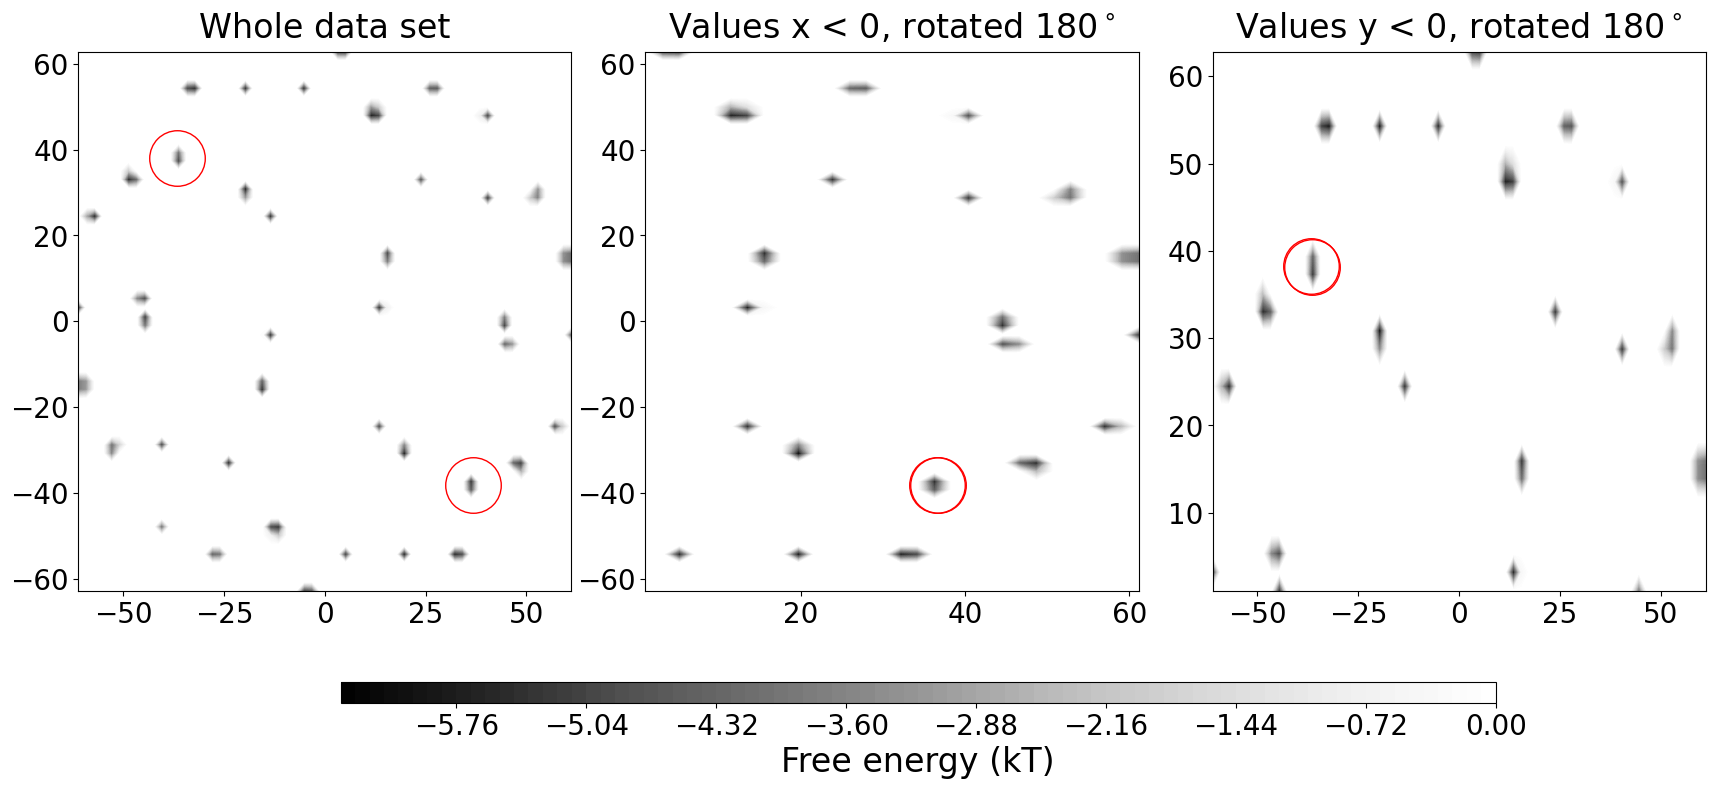

In [848]:
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# Plot with shared colorbar scale
cmap = 'Greys_r'
kBT = 1.0
plot, ax, CS0, (x, y, z) = plot_free_energy(
    red_cart_pol[:, 0], red_cart_pol[:, 1], weights=energy_org, nbins=60, ncountours=100, ax=axes[0],
    avoid_zero_count=True, minener_zero=True, kT=kBT,cmap=cmap, cbar=False,
    cbar_label='Free energy (kT)', white_bg=True)
axes[0].set_title('Whole data set', fontsize=24)

exp_positions = np.array([1, 9317])
for i in exp_positions:
    axes[0].plot(red_cart_pol[i, 0], red_cart_pol[i, 1], marker='o', linestyle='', markerfacecolor='none', markeredgecolor='red', markersize=40)

plot, ax, CS, (x, y, z) = plot_free_energy(
    red_cart_pol[:, 0], red_cart_pol[:, 1], weights=energy_org, nbins=60, ncountours=100, ax=axes[1],
    avoid_zero_count=True, minener_zero=True, kT=kBT, cmap=cmap, cbar=False,
    cbar_label='Free energy (kT)', white_bg=True, symmetry=True, x_sym=True)
axes[1].set_title(r'Values x < 0, rotated $180^\circ$', fontsize=24)

plot, ax, CS, (x, y, z) = plot_free_energy(
    red_cart_pol[:, 0], red_cart_pol[:, 1], weights=energy_org, nbins=60, ncountours=100, ax=axes[2],
    avoid_zero_count=True, minener_zero=True, kT=kBT, cmap=cmap, cbar=False,
    cbar_label='Free energy (kT)', white_bg=True, symmetry=True, y_sym=True)
axes[2].set_title(r'Values y < 0, rotated $180^\circ$', fontsize=24)

exp_positions = np.array([1, 9317])
for i in exp_positions:
    print(red_cart_pol[i])
    if red_cart_pol[i, 0] < 0:
        axes[1].plot(-red_cart_pol[i, 0], -red_cart_pol[i, 1], marker='o', linestyle='', markerfacecolor='none', markeredgecolor='red', markersize=40)
    else:
        axes[1].plot(red_cart_pol[i, 0], red_cart_pol[i, 1], marker='o', linestyle='', markerfacecolor='none', markeredgecolor='red', markersize=40)
for i in exp_positions:
    print(red_cart_pol[i])
    if red_cart_pol[i, 1] < 0:
        axes[2].plot(-red_cart_pol[i, 0], -red_cart_pol[i, 1], marker='o', linestyle='', markerfacecolor='none', markeredgecolor='red', markersize=40)
    else:
        axes[2].plot(red_cart_pol[i, 0], red_cart_pol[i, 1], marker='o', linestyle='', markerfacecolor='none', markeredgecolor='red', markersize=40)


cbar_ax = fig.add_axes([0.25, -0.05, 0.55, 0.03])  # [left, bottom, width, height] in figure coordinates
cbar = fig.colorbar(CS0, cax=cbar_ax, orientation='horizontal')


fig.subplots_adjust(wspace=0.15)  # Reduce horizontal space between plots
for ax in axes:
    ax.set_title(ax.get_title(), fontsize=24, pad=10)  # Move title higher (increase pad)
    ax.tick_params(axis='both', labelsize=20)  # Set font size to 20 for both axes

cbar.ax.tick_params(labelsize=20)
cbar.set_label('Free energy (kT)', fontsize=24)
#plt.savefig('pca_symmetry.pdf', bbox_inches='tight', dpi=300)

Nest, the upper part of Figure S6 is constructed below.

0.0 -6.402151569461921 (60, 60)
0.0 -5.254574090464738 (45, 45)
0.0 -5.628867469224065 (45, 45)


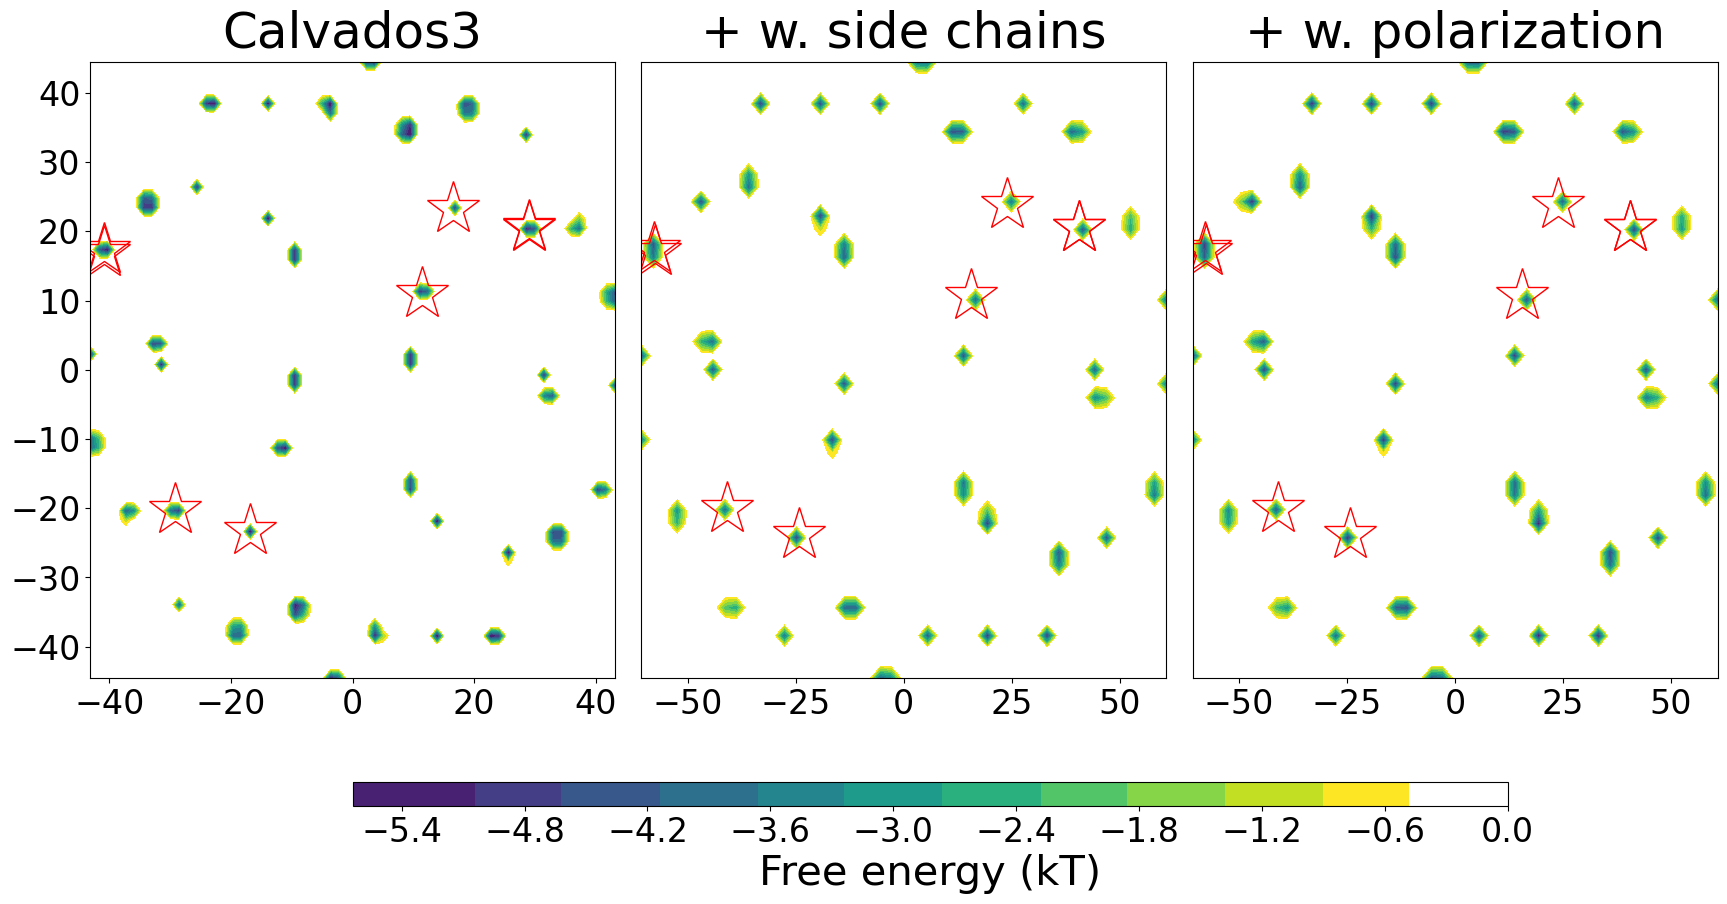

In [849]:
fig, axes = plt.subplots(1, 3, figsize=(21, 8))

all_weights = [energy_org, energy_sch, energy_pol]
all_X = [red_cart_org, red_cart_sch, red_cart_pol]
F_list = []

#Computing the 2D histogram of the PCA-reduced coordinates and normalizing it
# such that the min and max values are mapped to the color bar limits
for X, weights in zip(all_X, all_weights):
    z, xedge, yedge = np.histogram2d(X[:, 0], X[:, 1], bins=30, weights=weights)
    # Avoid zeros for log
    zmin_nonzero = np.min(z[np.where(z > 0)])
    z = np.maximum(z, zmin_nonzero)
    F = -np.log(z)
    F -= np.min(F)
    F_list.append(F)
# To get data to start at zero and decrease, switch the min and max and make min = -max
global_vmin = - max([np.max(F) for F in F_list]) #min([np.min(F) for F in F_list]) 
global_vmax = min([np.min(F) for F in F_list])  #max([np.max(F) for F in F_list]) 

# Plot with shared colorbar scale
viridis = cm.get_cmap('viridis', 12)

new_map = viridis(np.linspace(0, 1, 12))
new_map = new_map[1:]
new_map = np.concatenate((new_map,np.array([[1.0, 1.0, 1.0, 1.0]])), axis=0)
new_cmp = ListedColormap(new_map)
cmap = new_cmp 

kBT = 1.0 # set to one to get unit as kBT

plot, ax, CS, (x, y, z) = plot_free_energy(
    red_cart_org[:, 0], red_cart_org[:, 1], weights=energy_org, nbins=60, ncountours=100, ax=axes[0],
    avoid_zero_count=True, minener_zero=True, kT=kBT,
    vmin=global_vmin, vmax=global_vmax, cmap=cmap, cbar=False,
    cbar_label='Free energy (kT)', white_bg=True)
axes[0].set_title('Calvados3', fontsize=24)

plot, ax, CS, (x, y, z) = plot_free_energy(
    red_cart_sch[:, 0], red_cart_sch[:, 1], weights=energy_sch, nbins=45, ncountours=100, ax=axes[1],
    avoid_zero_count=True, minener_zero=True, kT=kBT,
    vmin=global_vmin, vmax=global_vmax, cmap=cmap, cbar=False,
    cbar_label='Free energy (kT)', white_bg=True)
axes[1].set_title('+ w. side chains', fontsize=24)

plot, ax, CS3, (x, y, z) = plot_free_energy(
    red_cart_pol[:, 0], red_cart_pol[:, 1], weights=energy_pol, nbins=45, ncountours=100, ax=axes[2],
    avoid_zero_count=True, minener_zero=True, kT=kBT,
    vmin=global_vmin, vmax=global_vmax, cmap=cmap, cbar=False,
    cbar_label='Free energy (kT)', white_bg=True)
axes[2].set_title('+ w. polarization', fontsize=24)

# Depending on numpy version (histogram count) the number of bins might need to be changed to get consistent results
cbar_ax = fig.add_axes([0.25, -0.05, 0.55, 0.03])  # [left, bottom, width, height] in figure coordinates
cbar = fig.colorbar(CS3, cax=cbar_ax, orientation='horizontal')

exp_positions = np.array([51, 379,1566, 9723, 15703, 18500, 19455,  20852])
for ax, idxs, red_cart in zip(axes, 
                             [exp_positions, 
                             exp_positions, 
                             exp_positions],
                             [red_cart_org, 
                             red_cart_sch, 
                             red_cart_pol]):
    for i in idxs:
        ax.plot(red_cart[i, 0], red_cart[i, 1], marker='*', linestyle='', markerfacecolor='none', markeredgecolor='red', markersize=40)

fig.subplots_adjust(wspace=0.05)  # Reduce horizontal space between plots
for ax in axes:
    ax.set_title(ax.get_title(), fontsize=36, pad=10)  # Move title higher (increase pad)
    ax.tick_params(axis='both', labelsize=24)  # Set font size to 20 for both axes
for ax in axes[1:]:
    ax.set_ylabel('')
    ax.tick_params(axis='y', left=False, labelleft=False)

cbar.ax.tick_params(labelsize=24)
cbar.set_label('Free energy (kT)', fontsize=30)
#plt.savefig('pca_full_data.pdf', bbox_inches='tight', dpi=300)

The lower part of Figure 3 and Figure S6 of the SI.

0.0 -6.402151569461921 (60, 60)
0.0 -5.254574090464738 (45, 45)
0.0 -5.628867469224065 (45, 45)


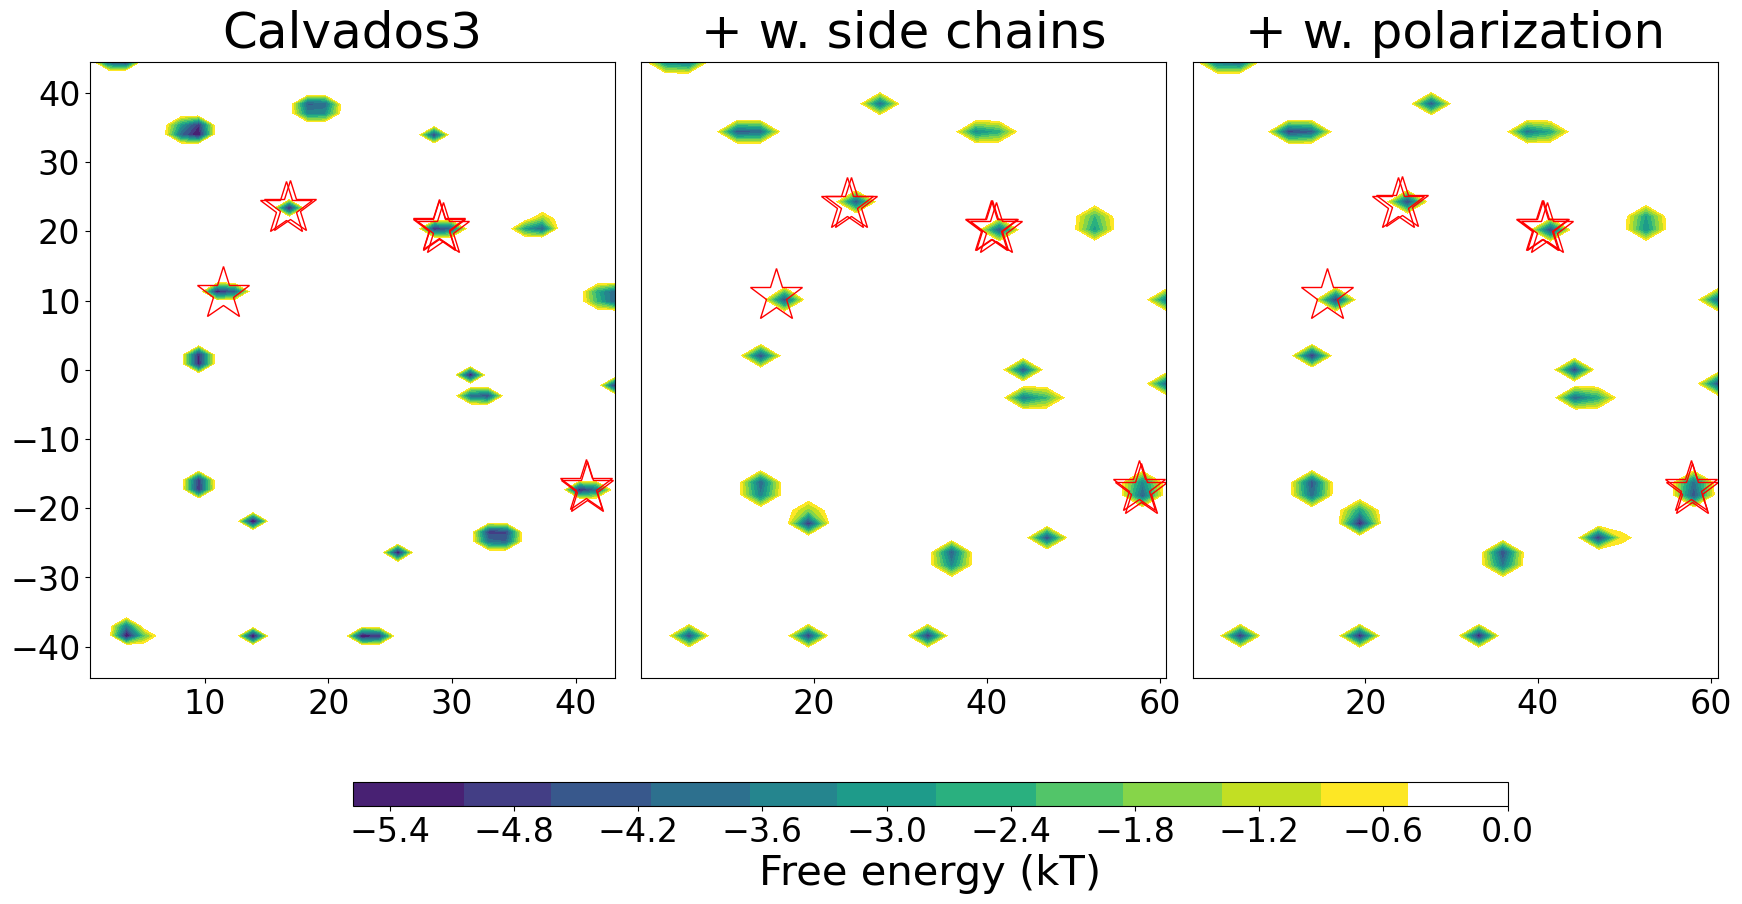

In [850]:
fig, axes = plt.subplots(1, 3, figsize=(21, 8))

all_weights = [energy_org, energy_sch, energy_pol]
all_X = [red_cart_org, red_cart_sch, red_cart_pol]
F_list = []

#Computing the 2D histogram of the PCA-reduced coordinates and normalizing it
# such that the min and max values are mapped to the color bar limits
for X, weights in zip(all_X, all_weights):
    z, xedge, yedge = np.histogram2d(X[:, 0], X[:, 1], bins=30, weights=weights)
    # Avoid zeros for log
    zmin_nonzero = np.min(z[np.where(z > 0)])
    z = np.maximum(z, zmin_nonzero)
    F = -np.log(z)
    F -= np.min(F)
    F_list.append(F)
# To get data to start at zero and decrease, switch the min and max and make min = -max
global_vmin = - max([np.max(F) for F in F_list]) #min([np.min(F) for F in F_list]) 
global_vmax = min([np.min(F) for F in F_list])  #max([np.max(F) for F in F_list]) 

# Plot with shared colorbar scale
viridis = cm.get_cmap('viridis', 12)

new_map = viridis(np.linspace(0, 1, 12))
new_map = new_map[1:]
new_map = np.concatenate((new_map,np.array([[1.0, 1.0, 1.0, 1.0]])), axis=0)
new_cmp = ListedColormap(new_map)
cmap = new_cmp 

kBT = 1.0 # set to one to get unit as kBT

plot, ax, CS, (x, y, z) = plot_free_energy(
    red_cart_org[:, 0], red_cart_org[:, 1], weights=energy_org, nbins=60, ncountours=100, ax=axes[0],
    avoid_zero_count=True, minener_zero=True, kT=kBT,
    vmin=global_vmin, vmax=global_vmax, cmap=cmap, cbar=False,
    cbar_label='Free energy (kT)', white_bg=True, symmetry=True, x_sym=True)
axes[0].set_title('Calvados3', fontsize=24)

plot, ax, CS, (x, y, z) = plot_free_energy(
    red_cart_sch[:, 0], red_cart_sch[:, 1], weights=energy_sch, nbins=45, ncountours=100, ax=axes[1],
    avoid_zero_count=True, minener_zero=True, kT=kBT,
    vmin=global_vmin, vmax=global_vmax, cmap=cmap, cbar=False,
    cbar_label='Free energy (kT)', white_bg=True, symmetry=True, x_sym=True)
axes[1].set_title('+ w. side chains', fontsize=24)

plot, ax, CS3, (x, y, z) = plot_free_energy(
    red_cart_pol[:, 0], red_cart_pol[:, 1], weights=energy_pol, nbins=45, ncountours=100, ax=axes[2],
    avoid_zero_count=True, minener_zero=True, kT=kBT,
    vmin=global_vmin, vmax=global_vmax, cmap=cmap, cbar=False,
    cbar_label='Free energy (kT)', white_bg=True, symmetry=True, x_sym=True)
axes[2].set_title('+ w. polarization', fontsize=24)

# Depending on numpy version (histogram count) the number of bins might need to be changed to get consistent results
cbar_ax = fig.add_axes([0.25, -0.05, 0.55, 0.03])  # [left, bottom, width, height] in figure coordinates
cbar = fig.colorbar(CS3, cax=cbar_ax, orientation='horizontal')

exp_positions = np.array([51, 379,1566, 9723, 15703, 18500, 19455,  20852])
for ax, idxs, red_cart in zip(axes, 
                             [exp_positions, 
                             exp_positions, 
                             exp_positions],
                             [red_cart_org, 
                             red_cart_sch, 
                             red_cart_pol]):
    for i in idxs:
        if red_cart[i, 0] < 0:
            ax.plot(-red_cart[i, 0], -red_cart[i, 1], marker='*', linestyle='', markerfacecolor='none', markeredgecolor='red', markersize=40)
        else:
            ax.plot(red_cart[i, 0], red_cart[i, 1], marker='*', linestyle='', markerfacecolor='none', markeredgecolor='red', markersize=40)


fig.subplots_adjust(wspace=0.05)  # Reduce horizontal space between plots
for ax in axes:
    ax.set_title(ax.get_title(), fontsize=36, pad=10)  # Move title higher (increase pad)
    ax.tick_params(axis='both', labelsize=24)  # Set font size to 20 for both axes
for ax in axes[1:]:
    ax.set_ylabel('')
    ax.tick_params(axis='y', left=False, labelleft=False)

cbar.ax.tick_params(labelsize=24)
cbar.set_label('Free energy (kT)', fontsize=30)
#plt.savefig('pca_full_data.pdf', bbox_inches='tight', dpi=300)

Lastly, below is Figure S7 plotted. 

Reduced Cartesian coordinates shape: (21168, 2) (21168,)
0.0 -4.614698611257658 (35, 35)
[ 40.519493 -40.99274  -57.843422  15.59213  -57.67394  -24.284426
  40.47809   23.843876] [ 28.78846  -28.279148  24.49977   14.892132  23.92507  -33.528244
  28.692623  33.357304]


Text(0, 0.5, 'PCA Component 2')

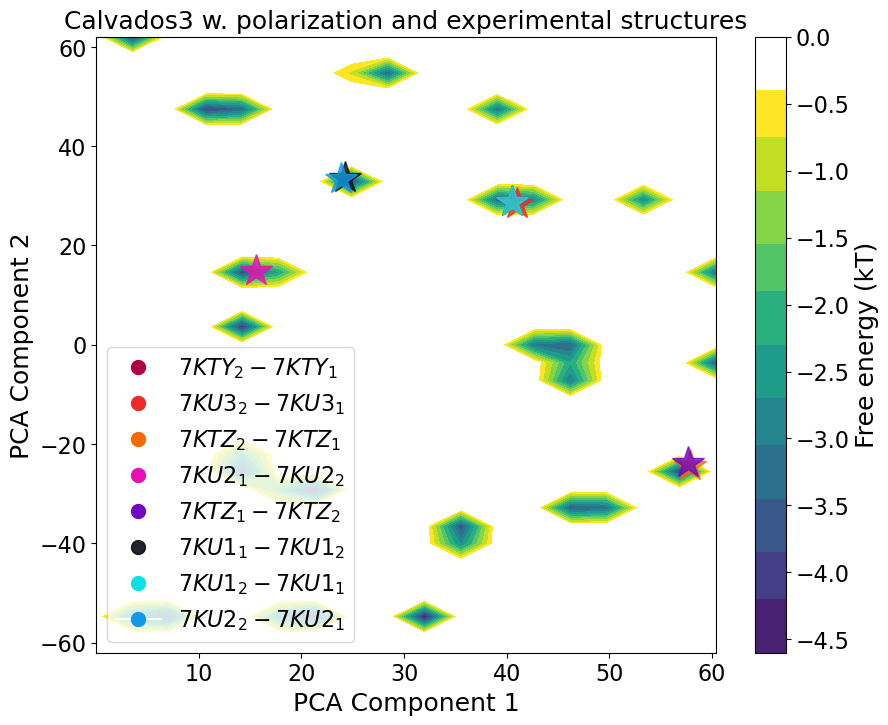

In [851]:
# Plotting PCA for w. polarization and the experimental structures a scatters
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
pca1 = PCA(n_components=2)

viridis = cm.get_cmap('viridis', 12)

new_map = viridis(np.linspace(0, 1, 12))
new_map = new_map[1:]
new_map = np.concatenate((new_map,np.array([[1.0, 1.0, 1.0, 1.0]])), axis=0)
new_cmp = ListedColormap(new_map)
cmap = new_cmp

red_cart = pca1.fit_transform(traj_pol.xyz.reshape(traj_pol.n_frames, traj_pol.n_atoms * 3))  # Flatten the trajectory to 2D
print("Reduced Cartesian coordinates shape:", red_cart.shape, energy_org.shape)
plot, ax, CS, (x, y, z) = plot_free_energy(
    red_cart[:, 0], red_cart[:, 1], weights=energy_org, nbins=35, ncountours=100, ax=axes,
    avoid_zero_count=True, minener_zero=True, kT=1.0,
    vmin=None, vmax=None, cmap=cmap, cbar=True,
    cbar_label='Free energy (kT)', white_bg=True, symmetry=True, x_sym=True)

ind = np.array([51, 379, 1566, 9723, 15703, 18500, 19455, 20852])
print( red_cart[ind, 0], red_cart[ind, 1])
# Names of experimental structures
names = [r'$7KTY_2-7KTY_1$',r'$7KU3_2-7KU3_1$' ,r'$7KTZ_2 - 7KTZ_1$', r'$7KU2_1-7KU2_2$', r'$7KTZ_1 - 7KTZ_2$', r'$7KU1_1-7KU1_2$' , r'$7KU1_2-7KU1_1$', r'$7KU2_2 - 7KU2_1$']  # Example labels for each selected frame
# Assign a unique color for each label, and use the same color for repeated labels
unique_labels = list(dict.fromkeys(names))  # Preserves order, removes duplicates
color_cycle =[ "#ae0141","#ee2b2b", "#f76904", "#ec0db4", "#7106c3", "#090c12e7", "#0fdfe6", "#1298e6ff"] #plt.cm.tab10.colors  # Use tab10 colormap for up to 10 distinct colors
label_to_color = {label: color_cycle[i % len(color_cycle)] for i, label in enumerate(unique_labels)}

for idxs, label_list, red_cart in zip([np.array([51, 379, 1566, 9723, 15703, 18500, 19455, 20852])],
                                           [names],
                                           [red_cart]):
    for i, (index, label) in enumerate(zip(idxs, label_list)):
        color = label_to_color[label]
        if red_cart[index, 0] < 0:
            axes.plot(-red_cart[index, 0], -red_cart[index, 1], marker='*', linestyle='', markerfacecolor=color, markeredgecolor=color, markersize=24, alpha=0.8, linewidth = 14, label=label if i == 0 else "")
        else:
            axes.plot(red_cart[index, 0], red_cart[index, 1], marker='*', linestyle='', markerfacecolor=color, markeredgecolor=color, markersize=24, alpha=0.8, linewidth = 14, label=label if i == 0 else "")
plt.title('Calvados3 w. polarization and experimental structures', fontsize=18)
handles = [plt.Line2D([0], [0], marker='o',color='w', markerfacecolor=label_to_color[label], markeredgecolor=label_to_color[label], markersize=10, label=label) for label in unique_labels]
axes.legend(handles=handles, loc='lower left', fontsize=16)
axes.tick_params(labelsize=16)

plt.xlabel('PCA Component 1', fontsize=18)
plt.ylabel('PCA Component 2', fontsize=18)
#plt.savefig('pca_and_exp.pdf', bbox_inches='tight', dpi=300)